In [ ]:
!pip install scanpy==1.10.2 anndata==0.10.8 umap-learn==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 pynndescent==0.5.13 h5py==3.9.0


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=374f082473f43c70c46b8c7cf6f62bc6b8f5cf4c31867b8dcbbaefcf9e4a4251
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: h5py
    Found existing installation: h5py 3.11.0
    Uninstalling h5py-3.11.0:
      Successfully uninstalled h5py-3.11.0
ERROR: pip's dependency resolver does not cu

In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.4 MB/s eta 0:00:00


In [ ]:
!pip install leidenalg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.3 MB/s eta 0:00:00


In [ ]:
!pip install python-louvain


In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pooch

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [ ]:
adata = sc.read_h5ad("dataset.h5ad")

In [ ]:
gene_names = pd.read_csv('gene_names.csv', header=None)

In [ ]:
if len(gene_names) == adata.shape[1] + 1:
    gene_names = gene_names.iloc[1:]
adata.var_names = gene_names[0].values

# Quality Control(QC)

In [ ]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

In [ ]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(axis=1) / adata.obs['n_counts']

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

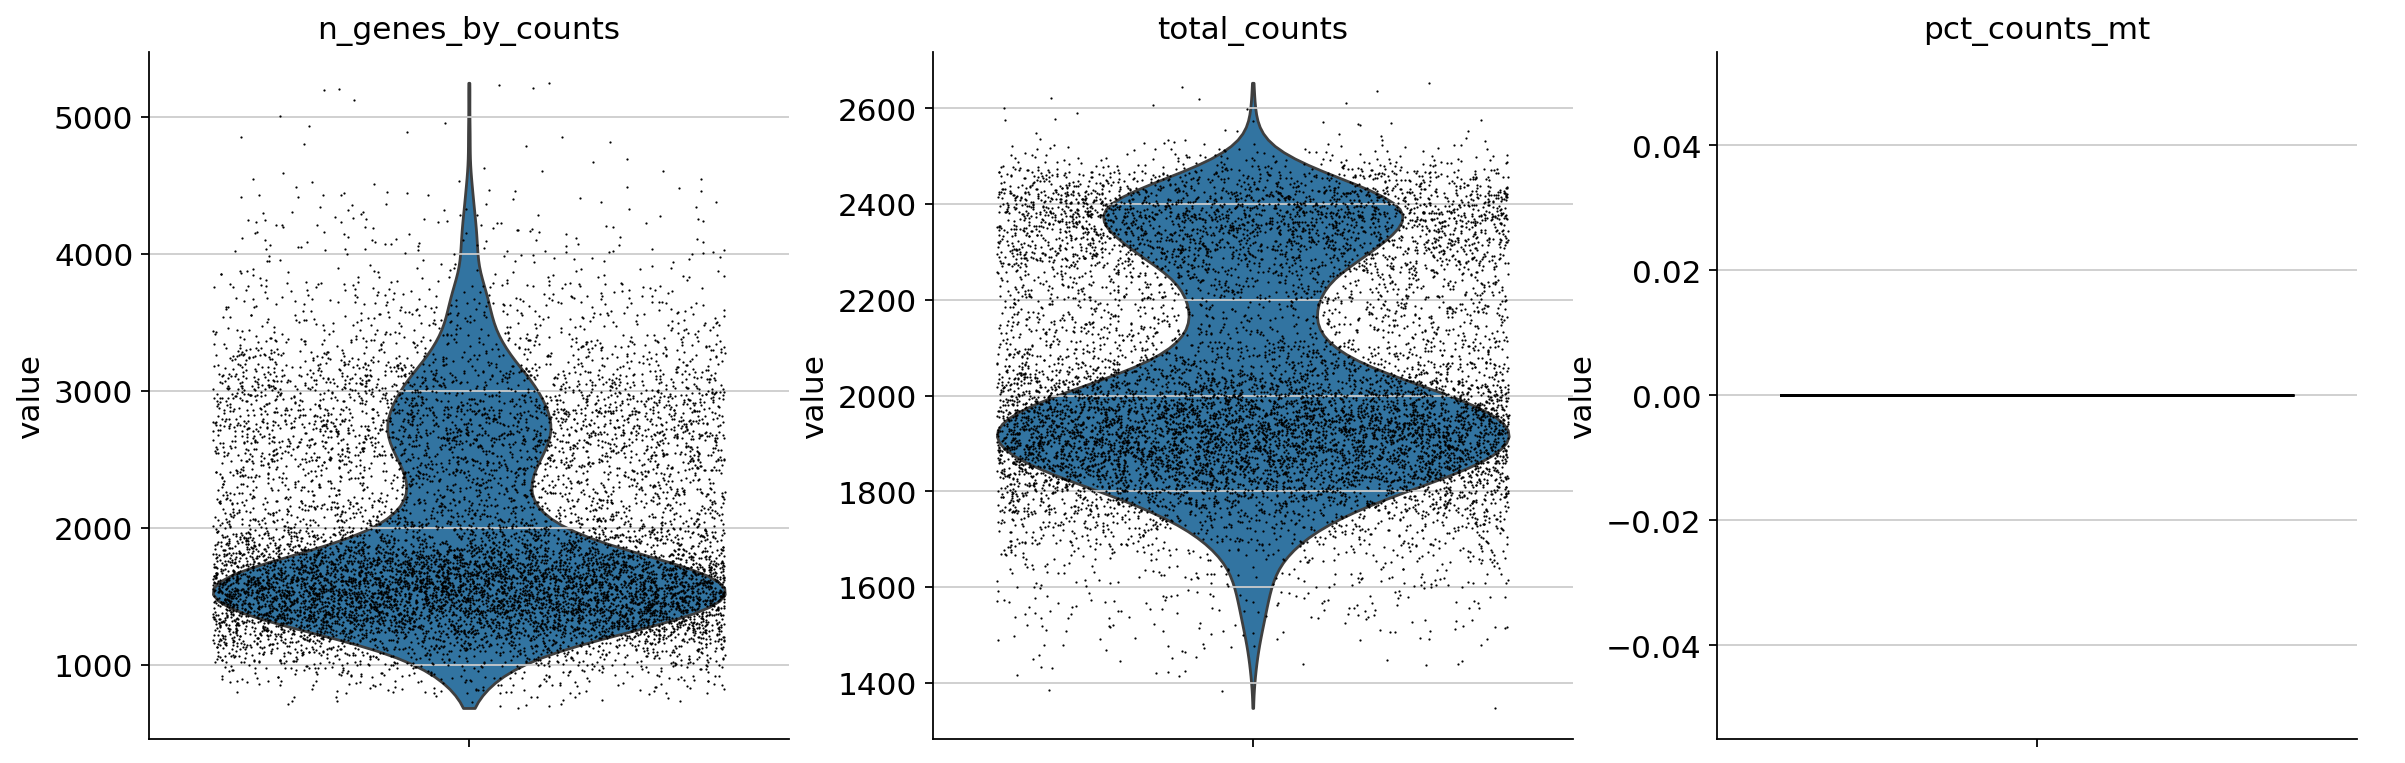

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

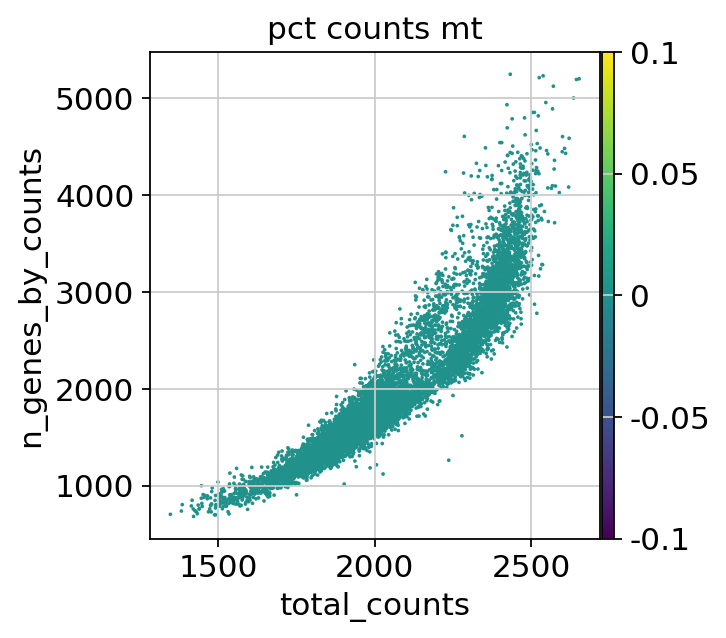

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 74 genes that are detected in less than 3 cells


In [ ]:
sc.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 69.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.2%
    Scrublet finished (0:02:13)


In [ ]:
adata.layers["counts"] = adata.X.copy()

# Normalize and Log Transform

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


# Feature Selection and PCA

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


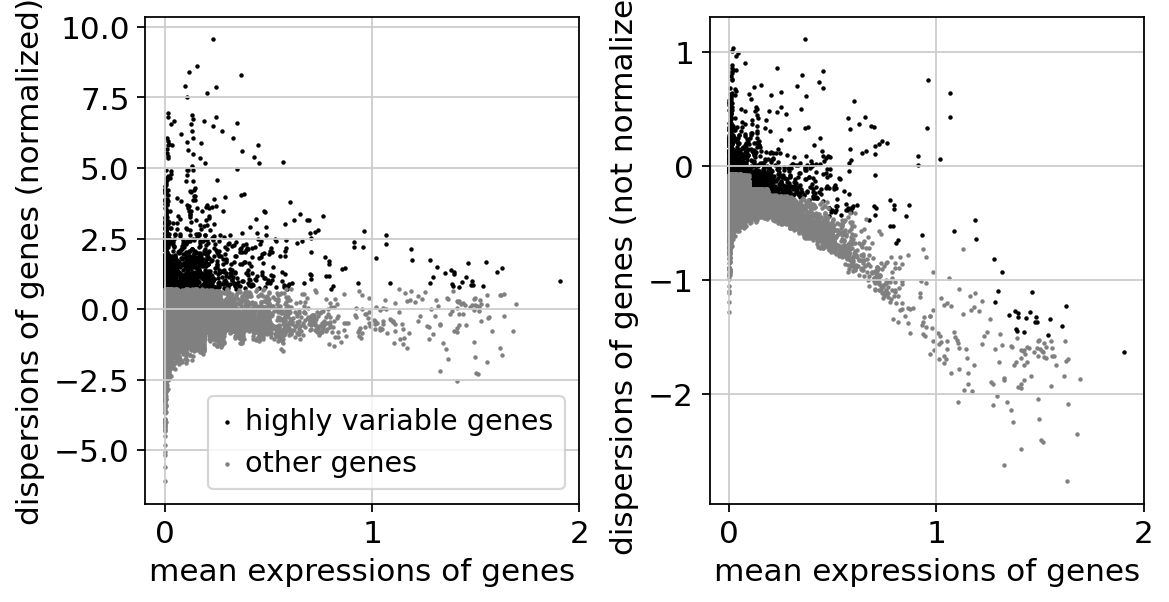

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:03)


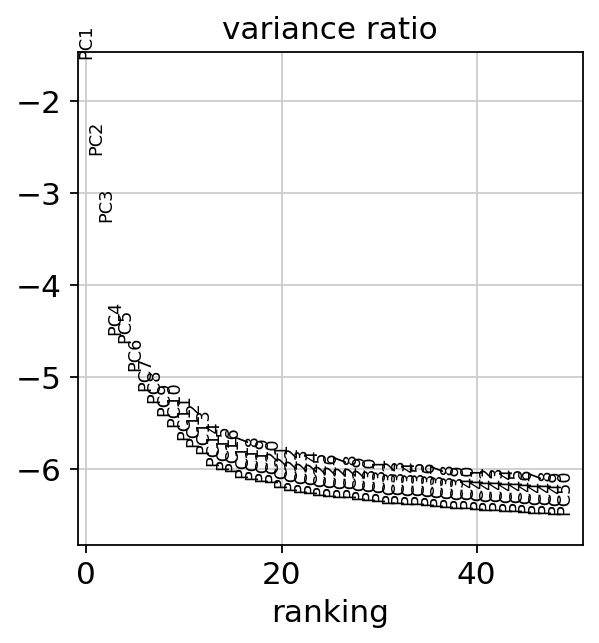

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [ ]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


# Louvian Clustering

In [ ]:
sc.tl.louvain(adata, flavor="igraph")

running Louvain clustering
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


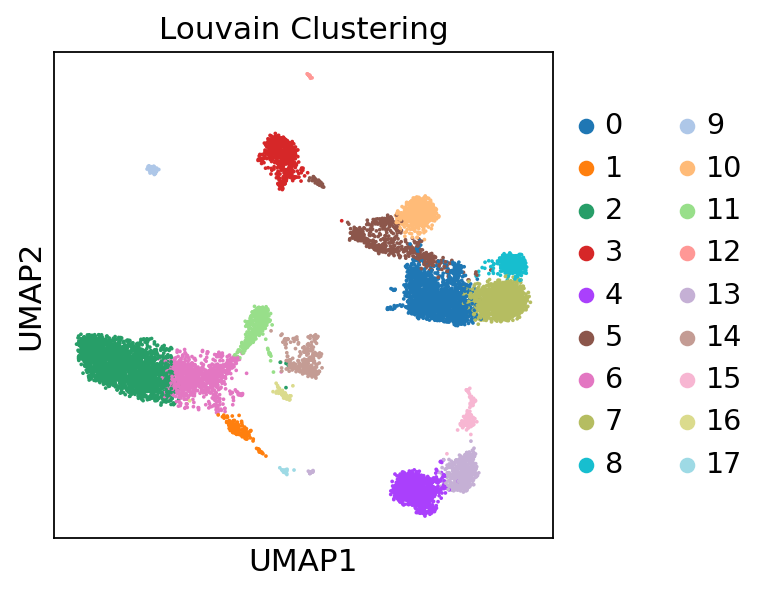

In [ ]:
sc.pl.umap(adata, color='louvain', title='Louvain Clustering')


running Louvain clustering
    finished: found 18 clusters and added
    'louvain_res_0_25', the cluster labels (adata.obs, categorical) (0:00:00)


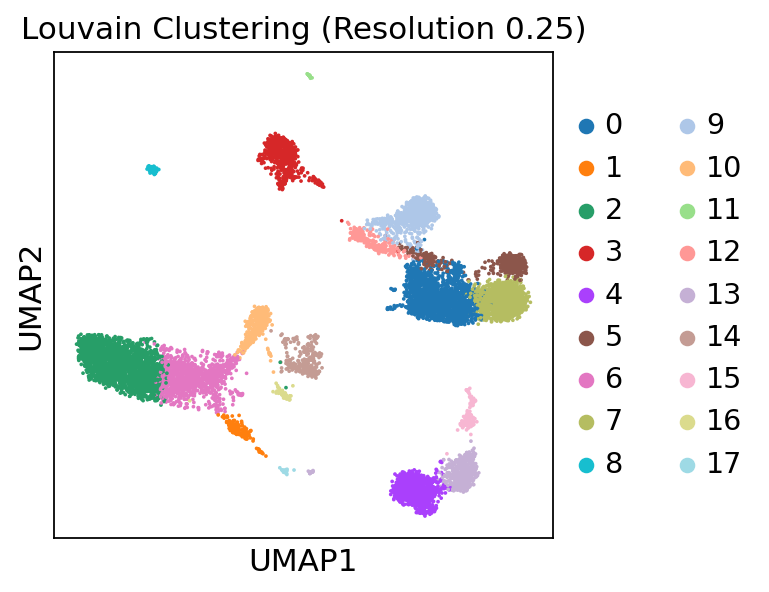

running Louvain clustering
    finished: found 18 clusters and added
    'louvain_res_0_50', the cluster labels (adata.obs, categorical) (0:00:00)


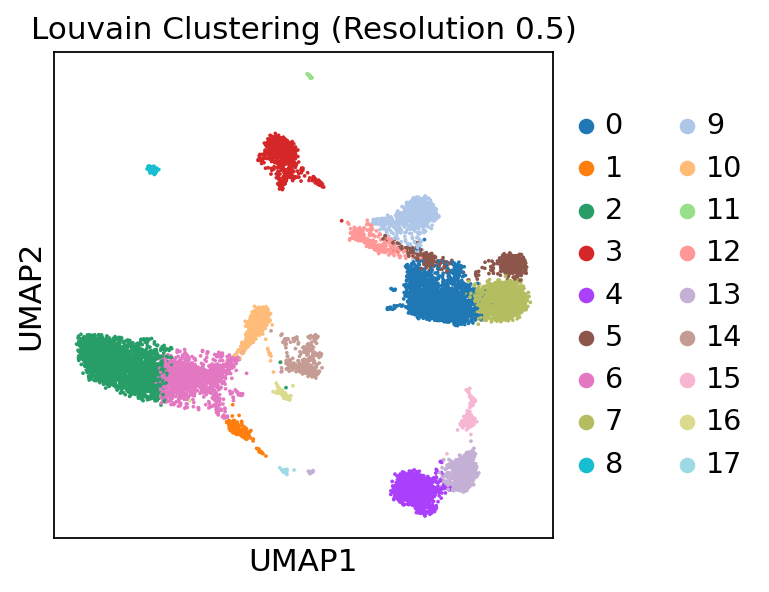

running Louvain clustering
    finished: found 18 clusters and added
    'louvain_res_0_75', the cluster labels (adata.obs, categorical) (0:00:01)


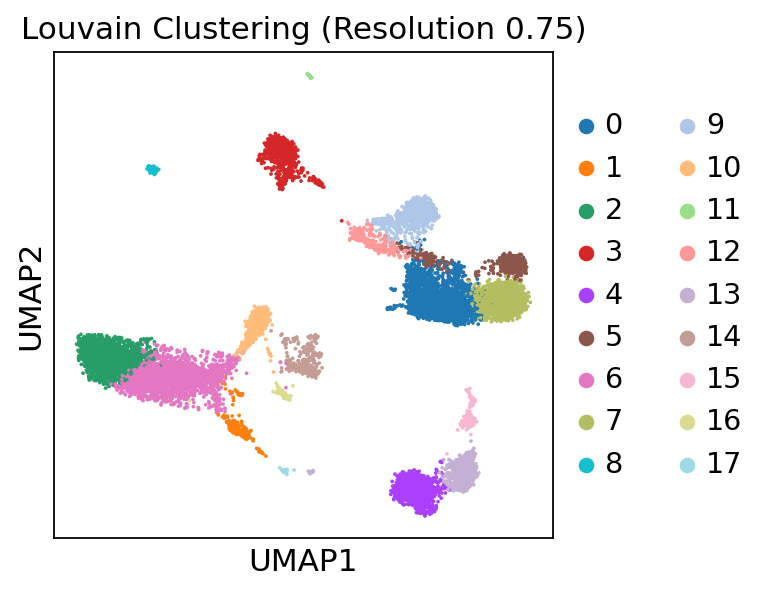

running Louvain clustering
    finished: found 18 clusters and added
    'louvain_res_1_00', the cluster labels (adata.obs, categorical) (0:00:00)


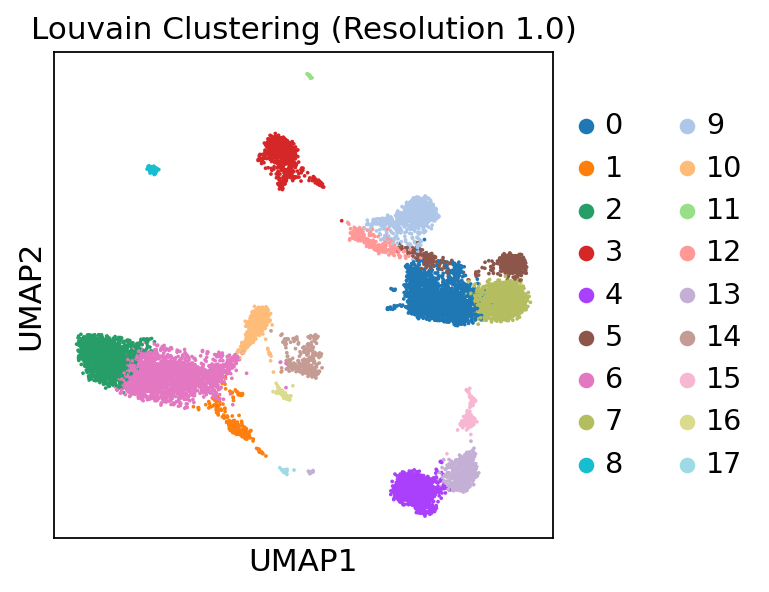

In [ ]:
for res in [0.25, 0.5, 0.75, 1.0]:
    res_str = f"{res:.2f}".replace('.', '_')
    sc.tl.louvain(
        adata,
        key_added=f"louvain_res_{res_str}",
        resolution=res,
        flavor="igraph"
    )

    sc.pl.umap(
        adata,
        color=f"louvain_res_{res_str}",
        title=f"Louvain Clustering (Resolution {res})"
    )


In [ ]:
!pip install louvain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.8 MB/s eta 0:00:00


In [ ]:
sc.tl.louvain(adata, key_added="louvain_res_0_50", resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_res_0_50', the cluster labels (adata.obs, categorical) (0:00:01)


In [ ]:
sc.tl.rank_genes_groups(
    adata,
    groupby="louvain_res_0_50",
    method="wilcoxon",
    key_added="dea_louvain_0_50"
)

ranking genes
    finished: added to `.uns['dea_louvain_0_50']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:31)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain_res_0_50']`


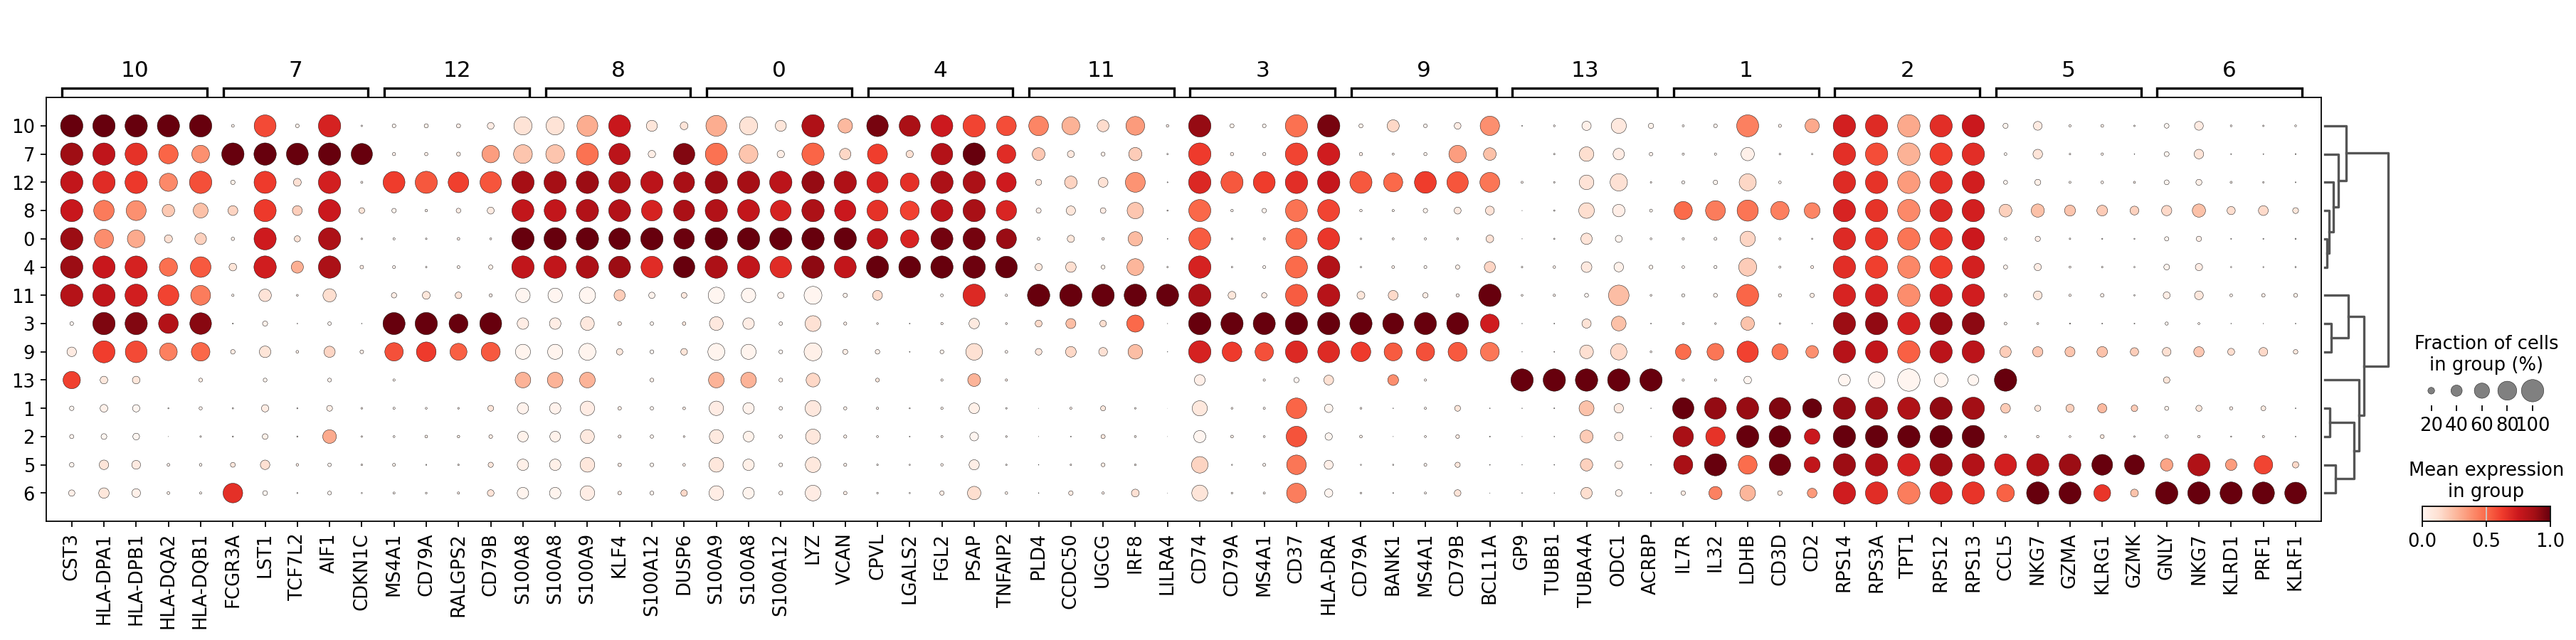

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="louvain_res_0_50", standard_scale="var", n_genes=5, key="dea_louvain_0_50"
)

In [ ]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
     key="dea_louvain_0_50",
    key_added="filtered0_5",
    )

Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2


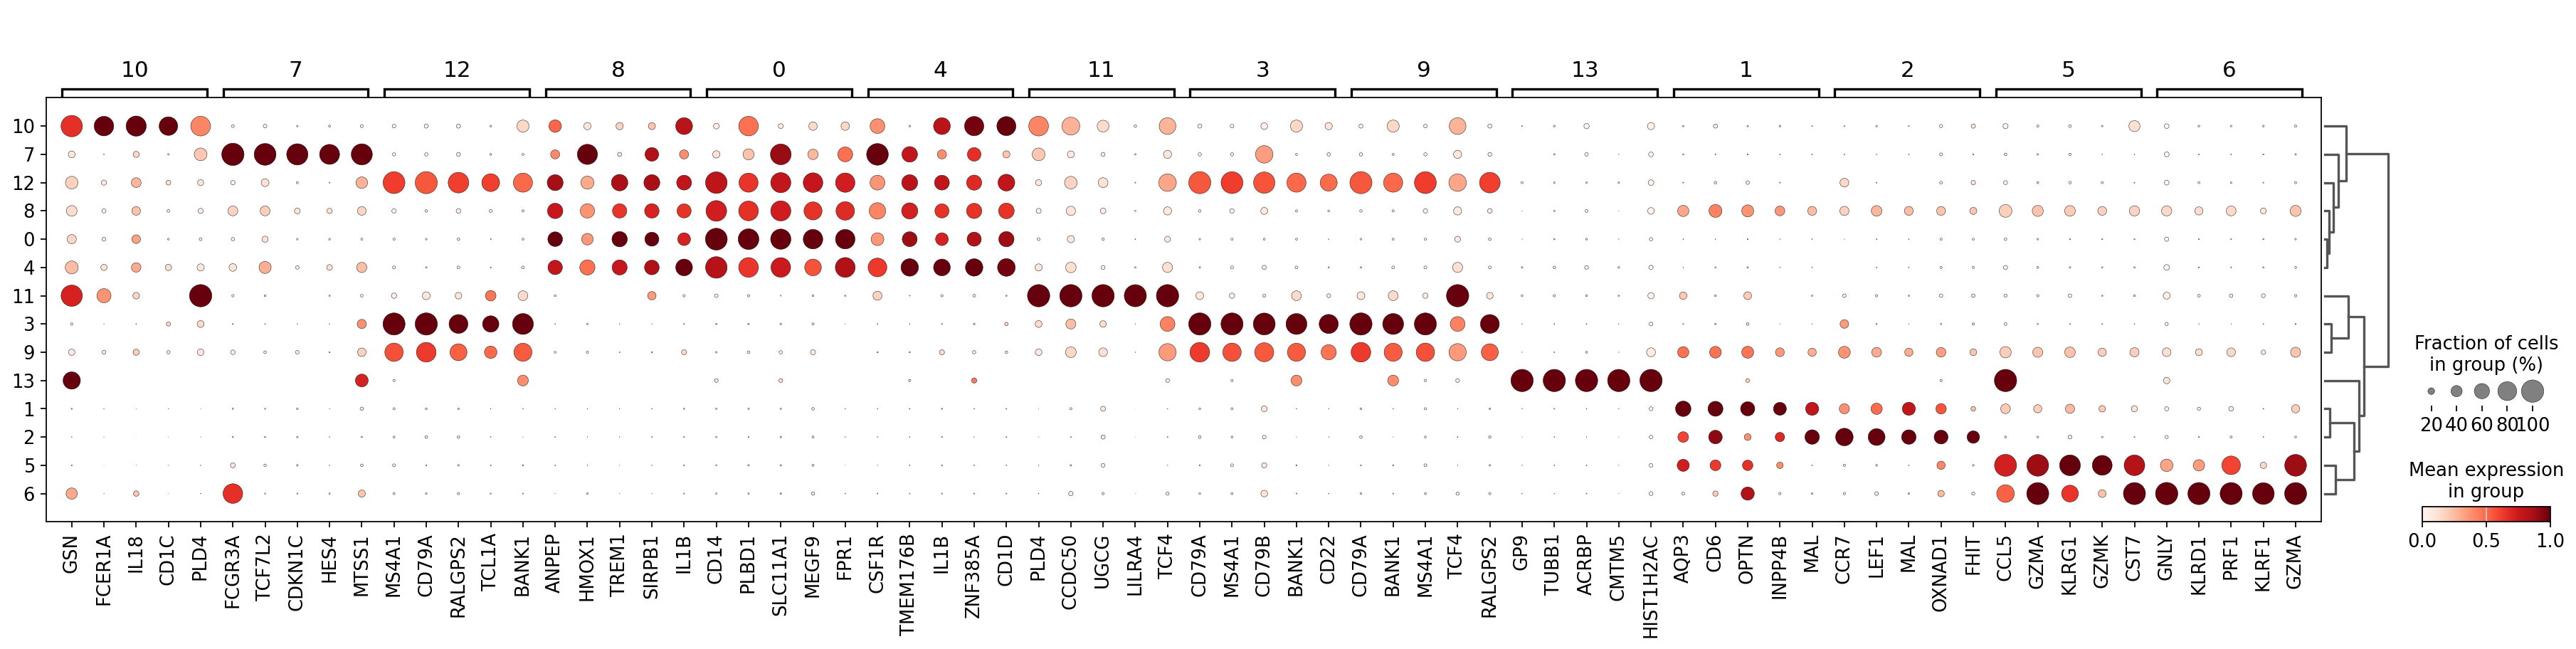

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="louvain_res_0_50", standard_scale="var", n_genes=5, key="filtered0_5"
)

# Annotation

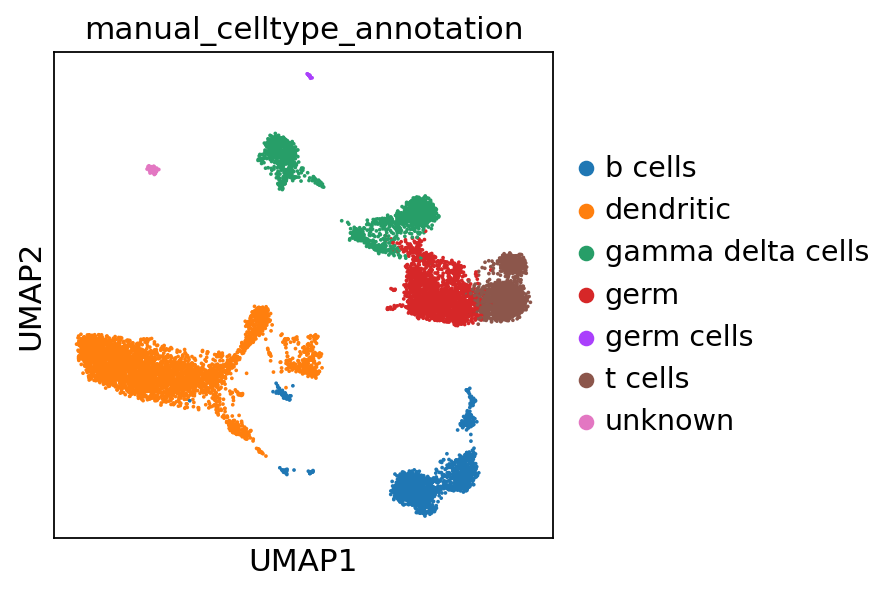

In [ ]:
cl_annotations = {
    '1': "germ", '2': "t cells", '0': "dendritic", '3': "b cells", '4': "dendritic",
    '5': "gamma delta cells", '6': "gamma delta cells", '7': "dendritic", '8': "dendritic", '9': "b cells",
    '10': "dendritic", '11': "unknown", '12': "b cells",'13': "germ cells"
}


adata.obs["manual_celltype_annotation"] = adata.obs['louvain_res_0_50'].map(cl_annotations)


adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].fillna("unknown")


sc.pl.umap(
    adata,
    color=["manual_celltype_annotation"],
)

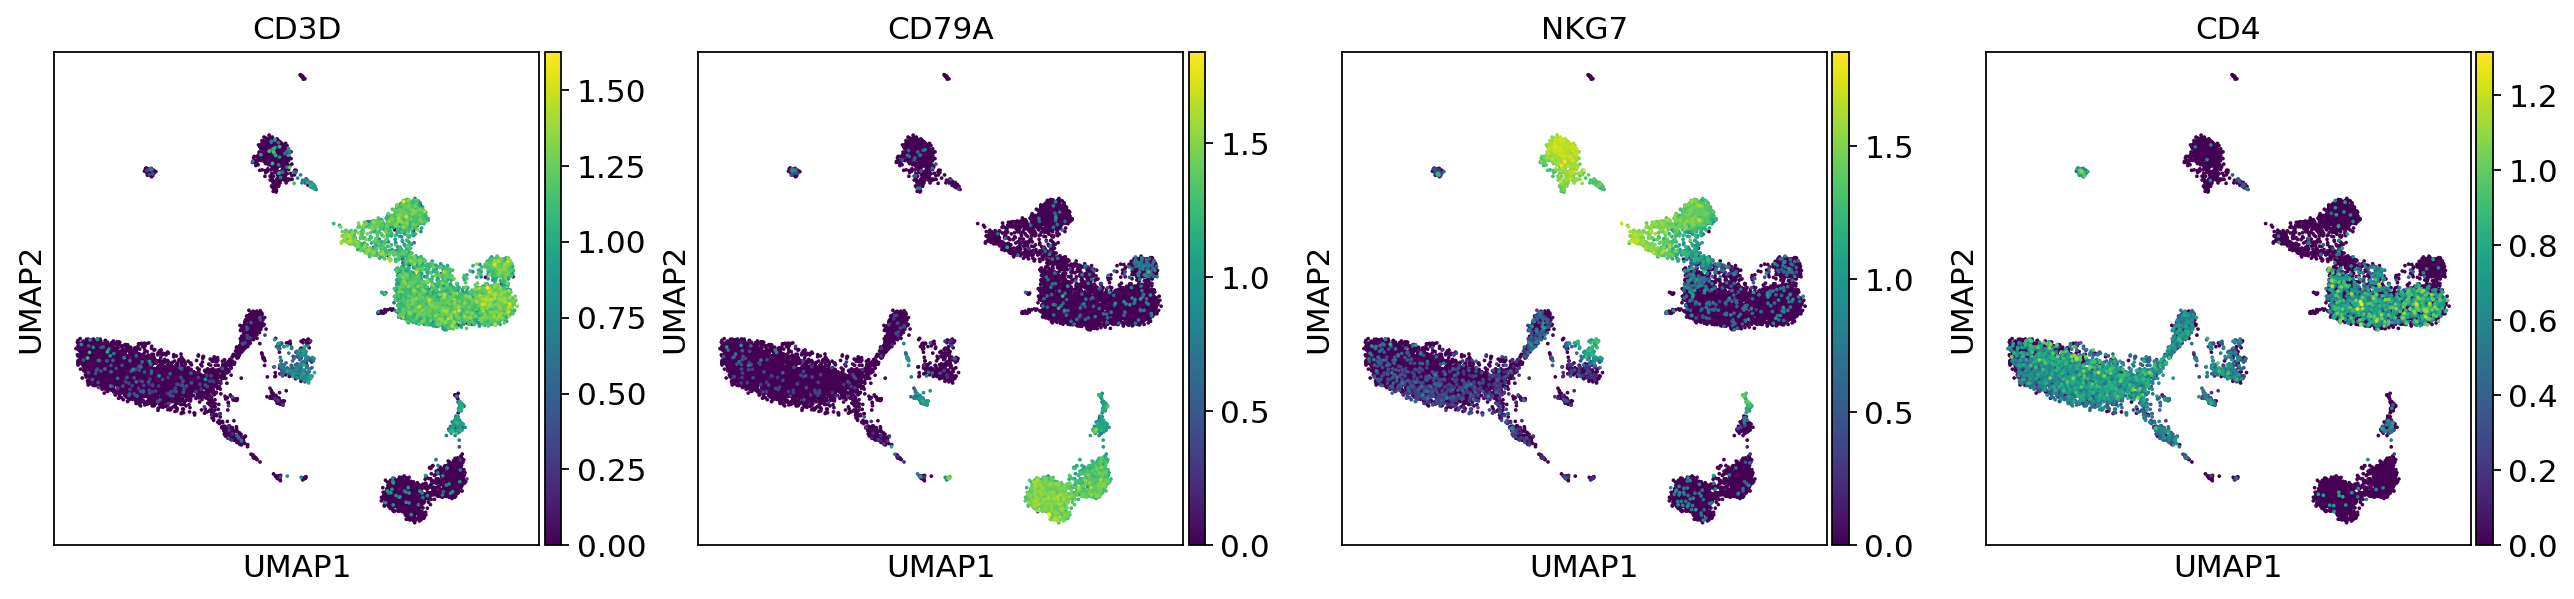

In [ ]:
sc.pl.umap(adata, color=["CD3D", "CD79A", "NKG7","CD4"])